In [1]:
# Load modules necessary
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from scipy.signal import detrend

%matplotlib ipympl

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load sample dataset

##### For EEG dataset, we will use CHB-MIT Scalp EEG Dataset from here: https://physionet.org/content/chbmit/1.0.0/chb01/#files-panel

##### The original dataset contains 22 subjects. However, here in this tutorial we will explore data from Subject 01
##### You can download the dataset from Brightspace

In [2]:
# Path to the EEG file
eegPath = '../../Datasets/EEG/sub-01/eeg/sub-01_task-daf_eeg_filtered.vhdr'

# Load the EEG file using MNE
# MNE has different read formats for different EEG file types
# Here we are using read_raw_edf to read the EEG file
# preload=True loads the data into memory (default is False, which loads the data when needed)
raw = mne.io.read_raw_brainvision(eegPath, preload=True)
elecPos = pd.read_csv('../../Datasets/EEG/sub-01/eeg/sub-01_electrodes.tsv', sep='\t')
# Add fiducials
fiducials = pd.DataFrame({
    'name': ['Nz', 'LPA', 'RPA'],
    'x': [-4.129838157917329e-18, -0.0729282673627754, 0.08278152042487033],
    'y': [0.10011015398430487, 3.008505424862354e-18, -3.414981080487009e-18],
    'z': [-5.7777898331617076e-33, 3.851859888774472e-34, 3.4666738998970245e-33]
})

# Concatenate the original electrode positions with the fiducials
elecPos = pd.concat([elecPos, fiducials], ignore_index=True)

montage = mne.channels.make_dig_montage(
    ch_pos=dict(zip(elecPos['name'], elecPos[['x', 'y', 'z']].values)),
    coord_frame='head'
)
raw.set_montage(montage)

Extracting parameters from ../../Datasets/EEG/sub-01/eeg/sub-01_task-daf_eeg_filtered.vhdr...
Setting channel info structure...
Reading 0 ... 244237  =      0.000 ...   976.948 secs...


<RawBrainVision | sub-01_task-daf_eeg_filtered.eeg, 66 x 244238 (976.9 s), ~123.1 MB, data loaded>

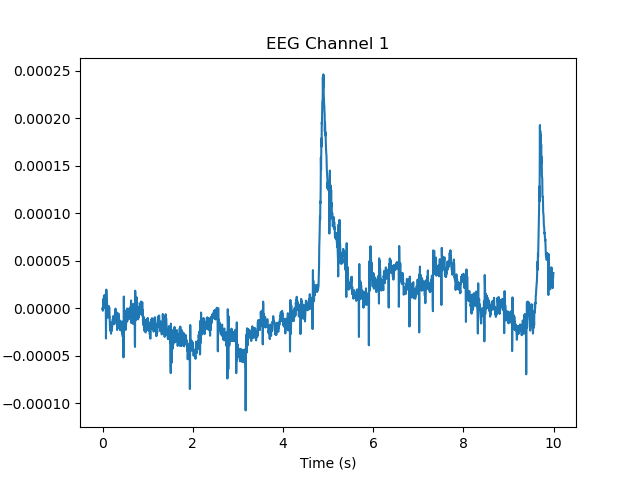

In [3]:
# Let us try plotting an EEG channel using matplotlib
# We can get the data of the EEG channel using get_data() function
# The data is in the form of a numpy array
data = raw.get_data()
chToPlot = 0 # Channel to plot
timeToPlot = 10 # Time in seconds to plot
plt.plot(raw.times[raw.times < timeToPlot], data[chToPlot, raw.times < timeToPlot])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('EEG Channel 1')
plt.show()

Using matplotlib as 2D backend.


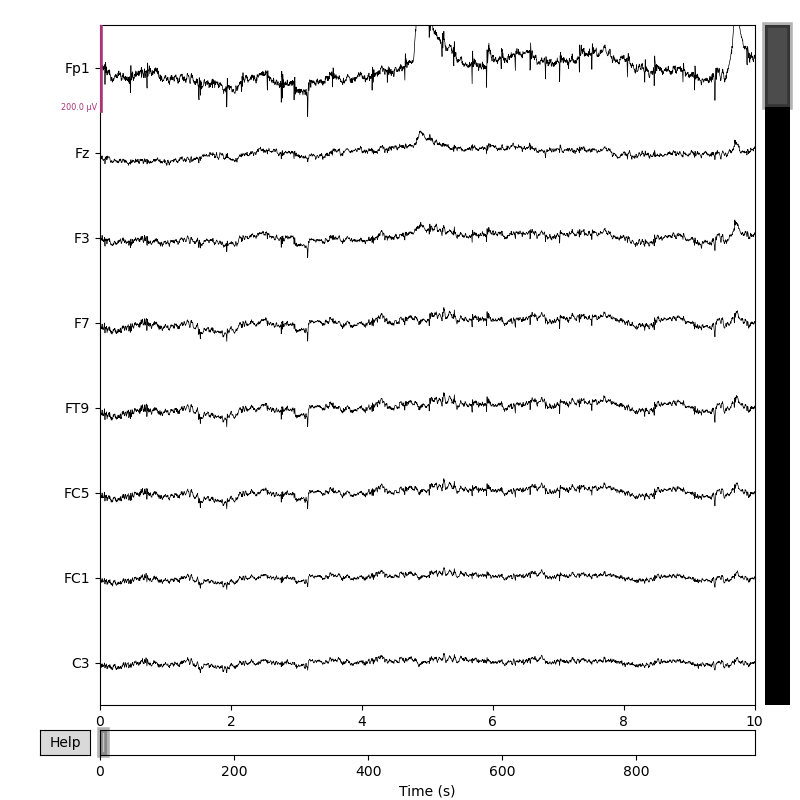

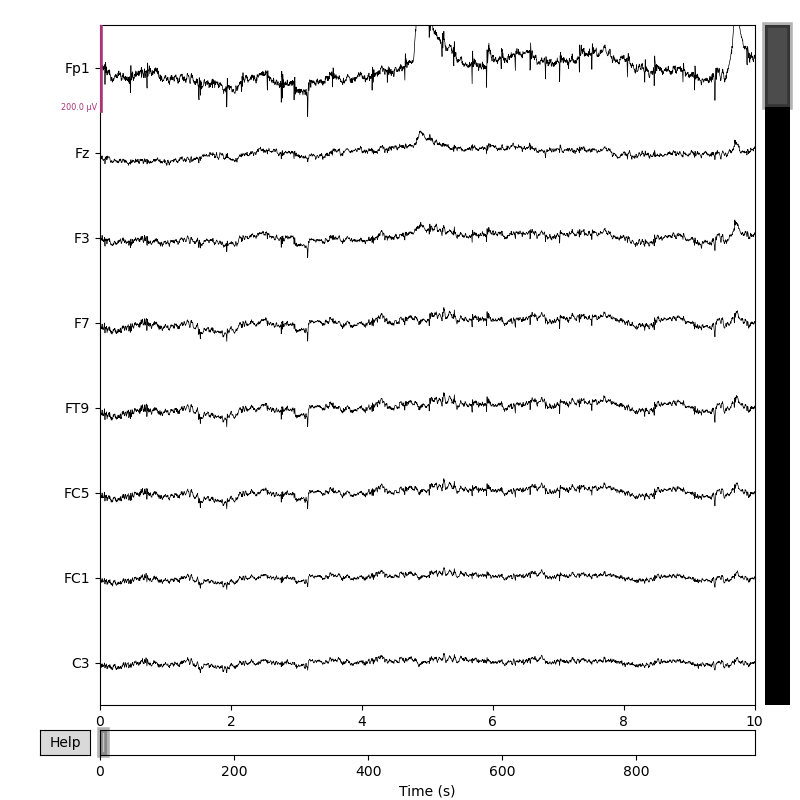

In [4]:
# Now let's try using the interactive plotting feature of MNE
# This is done by using the plot() function of the raw object
# This will open a new window where we can interactively plot the EEG data
# This is useful for exploring the data, checking for any artifacts, finding bad channels, or sections of recordings that need to be removed
raw.plot(scalings=10e-5, n_channels=8, title='EEG Data')
plt.show()

In [5]:
## Visualizing the montage of electrodes
# Plot montage using matplotlib as 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for dig_point in raw.info['dig']:
    # Check if dig point is a fiducial point
    if dig_point['kind'] == 1:
        ax.scatter(dig_point['r'][0], dig_point['r'][1], dig_point['r'][2], color='r', s = 100)
    else:
        ax.scatter(dig_point['r'][0], dig_point['r'][1], dig_point['r'][2], color='b', s = 25)
ax.set_axis_off()
ax.grid(False)
ax.view_init(elev=0, azim=90)
plt.show()

In [6]:
## Referencing data
# EEG data is usually recorded with respect to a reference electrode
# The reference electrode can be different for different EEG systems
# The data can be re-referenced to a common reference electrode, such as the average reference, linked mastoids, etc.
# Here we are going to re-reference the data using the average reference and the mastoids as reference electrodes
# The average refernce is calculated by taking the average of all the electrodes
raw_reref = raw.copy() # Create a copy of the raw object so that the original data is not modified
data_reref = raw_reref.get_data()
# Remove mean of all channels from each channel
data_reref = data_reref - np.mean(data_reref, axis=0, keepdims=True)
raw_reref._data = data_reref

# We can also rerefence data using a specific channel as the reference electrode
# For example, we can use the mastoids as reference electrodes
raw_reref2 = raw.copy()
elecIdxT7 = raw_reref2.ch_names.index('TP9')
elecIdxT8 = raw_reref2.ch_names.index('TP10')
data_reref2 = raw_reref2.get_data()
data_reref2 = data_reref2 - (data_reref2[elecIdxT7, :] + data_reref2[elecIdxT8, :]) / 2
raw_reref2._data = data_reref2

f, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(10, 6))
elecToPlot = 10
timeToPlot = 5 # Time in seconds
# Plot the data before referencing
axs[0].plot(raw.times[raw.times <= timeToPlot], raw.get_data()[elecToPlot, raw.times <= timeToPlot])
axs[0].set_title('Original Data')

# Plot the data after referencing using average reference
axs[1].plot(raw_reref.times[raw_reref.times <= timeToPlot], raw_reref.get_data()[elecToPlot, raw_reref.times <= timeToPlot])
axs[1].set_title('Average Reference')

# Plot the data after referencing using first channel as references
axs[2].plot(raw_reref2.times[raw_reref2.times <= timeToPlot], raw_reref2.get_data()[elecToPlot, raw_reref2.times <= timeToPlot])
axs[2].set_title('Mastoid Reference')
plt.show()